# Introduction to the Monte Carlo method

Start by defining the Gibbs distribution:
$$P(\alpha) = e^{-E(\alpha)/kT}$$
this expression, defines the probability of observing a particular configuration of spins, $\alpha$. 
As you can see, the probability of $\alpha$ decays exponentially with increasing energy of $\alpha$, $E(\alpha)$,
where $k$ is the Boltzmann constant, $k = 1.38064852 \times 10^{-23} J/K$
and $T$ is the temperature in Kelvin. 

## What defines the energy of a configuration of spins? 
Given a configuration of spins (e.g., $\uparrow\downarrow\downarrow\uparrow\downarrow$) we can define the energy using what is referred to as an Ising Hamiltonian:
$$ \hat{H}' = \frac{\hat{H}}{k} = -\frac{J}{k}\sum_{<ij>} s_is_j + \tfrac{\mu}{k}\sum_i s_i,$$
where, $s_i=1$ if the $i^{th}$ spin is `up` and $s_i=-1$ if it is `down`, and the brackets $<ij>$ indicate a sum over spins that are connected,
and $J$ is a constant that determines the energy scale. 
The energy here has been divided by the Boltzmann constant to yield units of temperature. 
Let's consider the following case, which has the sites connected in a single 1D line:
$$\alpha = \uparrow-\downarrow-\downarrow-\uparrow-\downarrow.$$ 
What is the energy of such a configuration?
$$ E(\alpha)' = -J/k(-1 + 1 - 1 - 1) = \frac{E(\alpha)}{k} = -2J/k - \mu$$

## Properties
For any fixed state, $\alpha$, the `magnetization` ($M$) is proportional to the _excess_ number of spins pointing up or down while the energy is given by the
Hamiltonian:
$$M(\alpha) = N_{\text{up}}(\alpha) - N_{\text{down}}(\alpha).$$
As a dynamical, fluctuating system, each time you measure the magnetization, the system might be in a different state ($\alpha$) and so you'll get a different number!
However, we already know what the probability of measuring any particular $\alpha$ is, so in order to compute the average magnetization, $\left<M\right>$, we just need to multiply the magnetization of each possible configuration times the probability of it being measured, and then add them all up!
$$ \left<M\right> = \sum_\alpha M(\alpha)P(\alpha).$$
In fact, any average value can be obtained by adding up the value of an individual configuration multiplied by it's probability:
$$ \left<E\right> = \sum_\alpha E(\alpha)P(\alpha).$$

This means that to obtain any average value (also known as an `expectation value`) computationally, we must compute the both the value and probability of all possible configurations. This becomes extremely expensive as the number of spins ($N$) increases. 

In [9]:
# from numba import jit

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import montecarlo
import random

# boltzmann constant, k = 1.38064852 × 10-23 m^2 kg s-2 K-1
N = 8


conf = montecarlo.SpinConfig1D(N=N)
conf.set_config([0, 0, 0, 0, 0, 0, 1, 1])
# conf.initialize(M=2)
ham = montecarlo.IsingHamiltonian1D(-1.0, .1)

Ei = ham.energy(conf)
Pi = np.e**(-Ei)
print(" Energy of      ", conf.config, " is ", Ei)
# print(" Probability of ", conf.config, " is ", Pi)

conf.set_int_config(106)
print(" Index 16 = ", conf)
Ei = ham.energy(conf)
print(" Energy of      ", conf.config, " is ", Ei)



 Energy of       [0 0 0 0 0 0 1 1]  is  3.6
 Index 16 =  01101010
 Energy of       [0 1 1 0 1 0 1 0]  is  -4.0


# Question 1
How many configurations are possible for:

(a) N=10?

(b) N=100?

(c) N=1000?

# Sampling
These calculation pose a drastic problem from a practical perspective. 
 As $N$ becomes large it is evident that
computations become a daunting task if calculated in this manner.
 Thus a better numerical alternative would be to use a simulation to generate data over
the ‘representative states’. 
Because each computed value of a configuration gets weighted by it's probability, very high energy states (which have negligible probabilities due to the Boltzmann distribution) will not contribute to the overall sum.  
This is a form of biased sampling which
essentially boils down to satisfying the following condition where
`generated frequency` = `actual probability`.

An expectation value of any quantity, $A$, computed (using the Canonical Ensemble) can also be defined as:
$$\left<A\right> = \frac{1}{Z}\int e^{-E(\alpha)/T}A(\alpha)d\alpha,$$
where $Z$ is referred to as the `partition function`, and is essentially a normalization constant:
$$ Z = \int e^{-E(\alpha)/T}d\alpha,$$ and
$$ P(\alpha) = \frac{1}{Z}e^{-E(\alpha)/T}.$$
This probability gives the actual statistical weight with which the configuration
$\alpha$ occurs in the thermal equilibrium. We now want to consider the discrete case
of the formal definitions above. If we are to consider a finite portion of the
configuration space it would produces an average of the form:
$$
\left<A\right> = \frac{\displaystyle\sum_\alpha e^{-E'(\alpha)/T}A(\alpha)}{\displaystyle\sum_\alpha e^{-E'(\alpha)/T}}$$

We could choose to randomly `sample` from this full set of configurations, but this will not converge quickly. 

---
## What is the energy for (++-+---+--+)?

In [2]:
conf = montecarlo.SpinConfig1D(N=11)

conf.set_config([1,1,0,1,0,0,0,1,0,0,1])
# conf.initialize(M=2)
ham = montecarlo.IsingHamiltonian1D(2.0, 1.1)
print(" Energy = %12.8f" %ham.energy(conf))

 Energy =   0.90000000


----
# Energy/Magnetization vs Temperature (exact)

In [10]:
def compute_average_values(ham, conf, T):
    E  = 0.0
    M  = 0.0
    Z  = 0.0
    EE = 0.0
    MM = 0.0

    for i in range(conf.n_dim):
        conf.set_int_config(i)
        Ei = ham.energy(conf)
        Zi = np.exp(-Ei/T)
        E += Ei*Zi
        EE += Ei*Ei*Zi
        Mi = np.sum(2*conf.config-1)
        M += Mi*Zi
        MM += Mi*Mi*Zi
        Z += Zi
    
    E = E/Z
    M = M/Z
    EE = EE/Z
    MM = MM/Z
    
    HC = (EE - E*E)/(T*T)
    MS = (MM - M*M)/T
    return E, M, HC, MS

    

In [3]:
# Define my hamiltonian values
ham.J = -2   
ham.mu = 1.1 
ham.pbc = True

# Define a new configuration instance for a 2-site lattice
conf = montecarlo.SpinConfig1D(N=6)

# Compute the average values for Temperature = 1
E, M, HC, MS = ham.compute_average_values(conf, 1)


print(" E  = %12.8f" %E)
print(" M  = %12.8f" %M)
print(" HC = %12.8f" %HC)
print(" MS = %12.8f" %MS)

 E  = -11.90432015
 M  =  -0.02660820
 HC =   0.59026994
 MS =   0.05404295


 Number of configurations:  256
 Critical Temperature:   2.00000000 
     E:   -3.73231850
     M:   -0.14658168
     HC:   1.64589165
     MS:   1.46663062
 Critical Temperature:   1.00000000
 E =  -3.73231850 @ T =   2.00000000


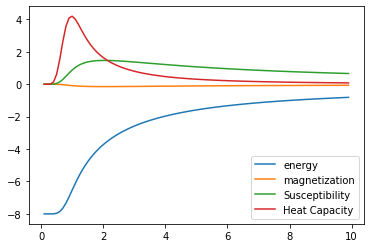

In [12]:

e_list = []
e2_list = []
m_list = []
m2_list = []
T_list = []

ham.J = -1
ham.mu = .1

conf = montecarlo.SpinConfig1D(N=8)
print(" Number of configurations: ", conf.n_dim)


for Ti in range(1,100):
    T = .1*Ti
    
    E, M, HC, MS = ham.compute_average_values(conf, T)
    
    e_list.append(E)
    m_list.append(M)
    e2_list.append(HC)
    m2_list.append(MS)
    T_list.append(T)


plt.plot(T_list, e_list, label="energy");
plt.plot(T_list, m_list, label="magnetization");
plt.plot(T_list, m2_list, label="Susceptibility");
plt.plot(T_list, e2_list, label="Heat Capacity");
plt.legend();

Tc_ind = np.argmax(m2_list)
print(" Critical Temperature: %12.8f " %(T_list[Tc_ind]))
print("     E:  %12.8f" %(e_list[Tc_ind]))
print("     M:  %12.8f" %(m_list[Tc_ind]))
print("     HC: %12.8f" %(e2_list[Tc_ind]))
print("     MS: %12.8f" %(m2_list[Tc_ind]))
Tc2 = T_list[np.argmax(e2_list)]
print(" Critical Temperature: %12.8f" %(Tc2))

print(" E = %12.8f @ T = %12.8f"% (e_list[T_list.index(2.00)], 2.0))


----
# Energy/Magnetization vs Temperature (Metropolis Sampling)

In [13]:

def sweep(conf, T, ham):
    for site_i in range(conf.N):
                
        delta_e = 0.0

        # assume PBC
        iright = (site_i+1)%conf.N
        ileft  = (site_i-1)%conf.N
        if conf.config[ileft] == conf.config[iright]:
            if conf.config[ileft] == conf.config[site_i]:
                delta_e = 4.0*ham.J
            else:
                delta_e = -4.0*ham.J
                
        delta_e += 2*ham.mu * (2*conf.config[site_i]-1)


        # prob_trans = 1.0 # probability of transitioning
        accept = True
        if delta_e > 0:
            # prob_trans = np.exp(-delta_e/T)
            if random.random() > np.exp(-delta_e/T):
                accept = False
        if accept:
            if conf.config[site_i] == 0:
                conf.config[site_i] = 1
            else:
                conf.config[site_i] = 0
            # conf.flip_site(i)



def compute_montecarlo(ham, conf, T, n_samples, nburn, plot=True):
    Eseries   = np.zeros(n_samples)
    Mseries   = np.zeros(n_samples)
    EEseries  = np.zeros(n_samples)
    MMseries  = np.zeros(n_samples)
    
    Eavg  = 0.0
    Mavg  = 0.0
    EEavg = 0.0
    MMavg = 0.0
    
    # equilibrate
    for si in range(nburn):
        sweep(conf, T, ham)

    # accumulate
    for si in range(n_samples):
        sweep(conf, T, ham)
        Ei = ham.energy(conf)
        Mi = conf.get_magnetization()
        Eseries[si] = Ei
        Mseries[si] = Mi
        EEseries[si] = Ei*Ei
        MMseries[si] = Mi*Mi
        
    

    if plot:
        
        Eavg = np.zeros(len(Eseries))
        Estd = np.zeros(len(Eseries))
        Eavg[0] = Eseries[0]
        for i in range(1,len(Eseries)):
            Eavg[i] = np.mean(Eseries[0:i])
            Estd[i] = np.std(Eavg[0:i])

        plt.plot(Eseries, label="Energy")
        plt.plot(Eavg, label="avg(E)")
        # plt.plot(Estd, label="std(E)")
        plt.legend()

    # print(" <E> = %12.8f " %np.mean(Eseries))

    E  = np.mean(Eseries)
    M  = np.mean(Mseries)
    EE = np.mean(EEseries)
    MM = np.mean(MMseries)
    
    HC = (EE - E*E)/(T*T)
    MS = (MM - M*M)/T
    return E, M, HC, MS 


In [7]:
# prun compute_montecarlo(ham, conf, 2, 20000, 5000, plot=False)
conf = montecarlo.SpinConfig1D(N=N)
conf.initialize(M=4)
E, M, HC, MS = compute_montecarlo(ham, conf, 2, 200000, 1000, plot=False)

print("     E:  %12.8f" %(E))
print("     M:  %12.8f" %(M))
print("     HC: %12.8f" %(HC))
print("     MS: %12.8f" %(MS))
# Exact values
# E:   -3.73231850
# M:    0.14658168
# EE:   1.64589165
# MM:   1.46663062


     E:   -3.70007500
     M:    0.14685000
     HC:   1.68832160
     MS:   1.47168754


In [8]:
def run_T_scan(ham, Tstep, Tmax, n_mc_steps, n_burn):
    e_list = []
    m_list = []
    hc_list = []
    ms_list = []
    T_list = []
    T = 1*Tstep
    for Ti in range(int(Tmax/Tstep)):
        T += Tstep
        conf = montecarlo.SpinConfig1D(N=N)
        conf.initialize(M=int(N/2))
        E, M, HC, MS = compute_montecarlo(ham, conf, T, n_mc_steps, n_burn, plot=False)

        e_list.append(E)
        m_list.append(M)
        hc_list.append(HC)
        ms_list.append(MS)
        T_list.append(T)

    plt.plot(T_list, e_list, label="energy");
    plt.plot(T_list, m_list, label="magnetization");
    plt.plot(T_list, ms_list, label="Susceptibility");
    plt.plot(T_list, hc_list, label="Heat Capacity");
    plt.legend();

    # Tc_ind = np.argmax(m2_list)
    # print(" Critical Temperature: %12.8f " %(T_list[Tc_ind]))
    print("     E:  %12.8f" %(e_list[Tc_ind]))
    print("     M:  %12.8f" %(m_list[Tc_ind]))
    print("     EE: %12.8f" %(hc_list[Tc_ind]))
    print("     MM: %12.8f" %(ms_list[Tc_ind]))
    Tc2 = T_list[np.argmax(e2_list)]
    print(" Critical Temperature: %12.8f" %(Tc2))

In [9]:
# Compare two functions 
import montecarlo

T = 2

random.seed(3)
conf = montecarlo.SpinConfig1D(N=N)
conf.initialize(M=4)
E, M, HC, MS = compute_montecarlo(ham, conf, T, 50000, 2000, plot=False)
# %time E, M, HC, MS = compute_montecarlo(ham, conf, T, 50000, 2000, plot=False)
random.seed(3)
conf = montecarlo.SpinConfig1D(N=N)
conf.initialize(M=4)
# %time montecarlo.metropolis_montecarlo(ham, conf, T=T, nsweep=50000, nburn=2000)
e, m, ee, mm = montecarlo.metropolis_montecarlo(ham, conf, T=T, nsweep=5000, nburn=2000)
print("%12.8f" %E)
print("%12.8f" %e[-1])


AttributeError: 'IsingHamiltonian1D' object has no attribute 'expectation_value'

In [ ]:
run_T_scan(ham, .1, 10, 100, 10)

     E:   -3.77240000
     M:    0.12400000
     EE:   1.65433974
     MM:   1.37553524
 Critical Temperature:   1.10000000


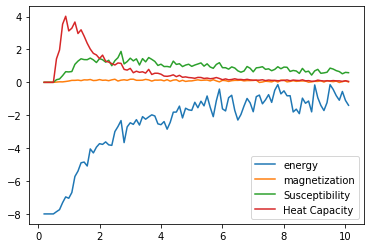

In [29]:
run_T_scan(ham, .1, 10, 500, 100)

Metropolis referenced from: [here](https://arxiv.org/pdf/0803.0217.pdf)


     E:   -3.75220000
     M:    0.16200000
     EE:   1.51212589
     MM:   1.44845524
 Critical Temperature:   1.10000000


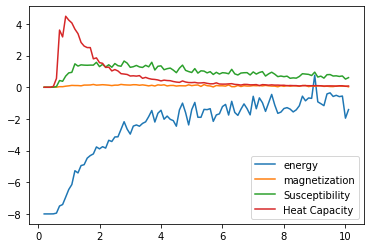

In [30]:
run_T_scan(ham, .1, 10, 1000, 100)

     E:   -3.32500000
     M:    0.13000000
     EE:   1.60756803
     MM:   1.56338095
 Critical Temperature:   1.10000000


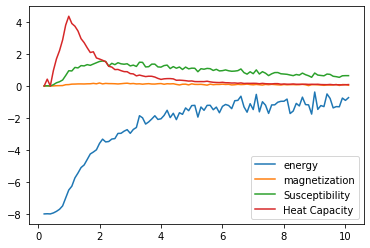

In [31]:
run_T_scan(ham, .1, 10, 2000, 200)

     E:   -3.58574000
     M:    0.14140000
     EE:   1.47338065
     MM:   1.47333621
 Critical Temperature:   1.10000000


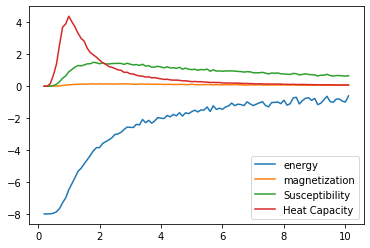

In [32]:
run_T_scan(ham, .1, 10, 10000, 1000)